In [13]:
# Download PDF
import os 
import requests

# GET PDF document
pdf_path = 'Mahabharata.pdf'

# Checking the file path
if not os.path.exists(pdf_path):
    print('File not there')
else:
    print('File already there')



File already there


In [16]:
# Requires !pip install PyMuPDF
import fitz
from tqdm.auto import tqdm # !pip install tqdm

def text_formatter(text: str) -> str:
    """Perform minor formatting on text"""
    cleaned_text = text.replace("\n"," ").strip() # note: this might be different for each doc (best to experient)

    # Other potential text formatting functions can go here
    return cleaned_text

# Open PDF and get lines/pages
# Note: this only focus on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, read its text context page by page, collects statistics.

    Parameters:
    pdf_path(str): The file to the PDF document to be opened and read.

    Returns:
    list[dict]: A list of dictionaries, each containing the page no. 
    (adjusted), character count, word_count, sentence_count, token_count, and extracted text
    for each page.
    """
    doc = fitz.open(pdf_path) # Open doc
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)): # iterate the document pages
        text = page.get_text() # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number":page_number+1, # adjusted page numbers since our PDF starts from 42
                                 "page_char_count": len(text),
                                 "page_word_count": len(text.split( )),
                                 "page_sentence_count_raw": len(text.split(". ")),
                                 "page_token_count": len(text)/4, # 1 token = ~4 char, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                 "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': 1,
  'page_char_count': 5126,
  'page_word_count': 861,
  'page_sentence_count_raw': 48,
  'page_token_count': 1281.5,
  'text': 'The Complete Mahabharata in English      The Mahabharata  of  Krishna-Dwaipayana Vyasa    BOOK 1  ADI PARVA        Translated into English Prose from the Original Sanskrit Text by Kisari Mohan Ganguli [1883-1896]    Scanned at sacred-texts.com, 2003. Proofed at Distributed Proofing, Juliet Sutherland, Project Manager. Additional proofing  and formatting at sacred-texts.com, by J. B. Hare.    TRANSLATOR\'S PREFACE  The object of a translator should ever be to hold the mirror upto his author. That being so, his chief duty is to represent so far as  practicable the manner in which his author\'s ideas have been expressed, retaining if possible at the sacrifice of idiom and taste  all the peculiarities of his author\'s imagery and of language as well. In regard to translations from the Sanskrit, nothing is easier  than to dish up Hindu ideas, so 

In [17]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 250,
  'page_char_count': 6712,
  'page_word_count': 1126,
  'page_sentence_count_raw': 38,
  'page_token_count': 1678.0,
  'text': 'generalissimo) Kartikeya and which was delightful and prosperous and full of kine and every kind of wealth and produce. And  the encounter the son of Pandu had with the Mattamyurakas of that country was fierce. And the illustrious Nakula after this,  subjugated the whole of the desert country and the region known as Sairishaka full of plenty, as also that other one called  Mahetta. And the hero had a fierce encounter with the royal sage Akrosa. And the son of Pandu left that part of the country  having subjugated the Dasarnas, the Sivis, the Trigartas, the Amvashtas, the Malavas, the five tribes of the Karnatas, and those  twice born classes that were called the Madhyamakeyas and Vattadhanas. And making circuitous journey that bull among men  then conquered the (Mlechcha) tribes called the Utsava-sanketas. And the illustrious hero soon br

In [19]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,1,5126,861,48,1281.5,The Complete Mahabharata in English The M...
1,2,6142,1015,52,1535.5,off. These were submitted to the judgment of a...
2,3,5392,870,22,1348.0,"Lastly, I should name my literary chief and fr..."
3,4,6668,1102,38,1667.0,"formed at the beginning of the Yuga, in which ..."
4,5,6100,1009,26,1525.0,"""Ganesa, upon hearing this address, thus answe..."


In [20]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,2328.00,2328.00,2328.00,2328.00,2328.00
mean,1164.50,6484.42,1095.51,47.10,1621.10
std,672.18,1444.36,250.03,12.46,361.09
min,1.00,339.00,56.00,1.00,84.75
25%,582.75,6297.75,1060.75,40.00,1574.44
50%,1164.50,6972.00,1175.00,47.00,1743.00
75%,1746.25,7404.25,1247.00,54.00,1851.06
max,2328.00,8163.00,1553.00,135.00,2040.75


In [ ]:
""" 
Now it looks like our average token count per page is 1621.

For this particular use case, it means we could embed an average whole page with the all-mpnet-base-v2
model(this model has an input capcity of 384).
"""

In [6]:
""" Futher text processing and splitting pages into sentences

There are two ways to do this:
1] By spliting the sentences by " . "  text = text.split(". ") , like we did it above
2] By the Libaraies like SpaCy and NLTK.

Pages text --> split into smaller chunks --> embed the group/chunks --> Use the embedding

Why split into sentence?
-- Easier to handle than larger pages of text (especially if pages are densely filled with text).
-- Can get specific and find out which group of sentences were used to help within RAG pipeline.

Now let's use SpaCy to break our text into sentences,
since it's likely a bit more robust than just using text.split(". ")
"""

' Futher text processing and splitting pages into sentences\n\nThere are two ways to do this:\n1] By spliting the sentences by " . "  text = text.split(". ") , like we did it above\n2] By the Libaraies like SpaCy and NLTK.\n\nPages text --> split into smaller chunks --> embed the group/chunks --> Use the embedding\n\nWhy split into sentence?\n-- Easier to handle than larger pages of text (especially if pages are densely filled with text).\n-- Can get specific and find out which group of sentences were used to help within RAG pipeline.\n\nNow let\'s use SpaCy to break our text into sentences,\nsince it\'s likely a bit more robust than just using text.split(". ")\n'

In [21]:
from spacy.lang.en import English # see https://spacy.io/usage for install instructions

nlp = English() 

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)

[This is a sentence., This another sentence.]

In [22]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences 
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/2328 [00:00<?, ?it/s]

In [23]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 351,
  'page_char_count': 6817,
  'page_word_count': 1174,
  'page_sentence_count_raw': 41,
  'page_token_count': 1704.25,
  'text': 'addressed by Damayanti, the venerable queen became filled with sorrow. And bathed in tears, she was unable to give any  answer. And beholding her in that plight, all the inmates of the inner apartments broke out into exclamation of \'Oh!\' And \'Alas\'!  and began to cry bitterly. And then the queen addressed the mighty monarch Bhima, saying, \'Thy daughter Damayanti  mourneth on account of her husband. Nay, banishing away all bashfulness, she hath herself, O king, declared her mind to me.  Let thy men strive to find out (Nala) the righteous.\' Thus informed by her the king sent theBrahmanas under him in all  directions, saying, \'Exert ye to discover Nala.\' And those Brahmanas, commanded by the ruler of the Vidarbhas (to seek Nala)  appeared before Damayanti and told her of the journey they were about to undertake. And Bhima\'s daughte

In [24]:
# Now let's turn out list of dictionaries into DataFrame and get some stats.

In [25]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,2328.00,2328.00,2328.00,2328.00,2328.00,2328.00
mean,1164.50,6484.42,1095.51,47.10,1621.10,57.00
std,672.18,1444.36,250.03,12.46,361.09,12.13
min,1.00,339.00,56.00,1.00,84.75,2.00
25%,582.75,6297.75,1060.75,40.00,1574.44,50.00
50%,1164.50,6972.00,1175.00,47.00,1743.00,56.00
75%,1746.25,7404.25,1247.00,54.00,1851.06,64.00
max,2328.00,8163.00,1553.00,135.00,2040.75,135.00


In [12]:
"""
Chunking our sentences together

Let's take a step to break down our list of sentences/text into smaller chunks.
As you might'vs gussed, this process is reffered to as chunking.

Why do we do this?
1. Easier to manage similar sized chunks of text.
2. Don't overload the embedding model capacity for tokens(eg. if an embedding model has a capacity of
    384 tokens, there could be information loss if you try to embbed a sequence of 400+ tokens).
3. Our LLM context window(the amount of tokens an LLM can take in) may be limited and requries compute
    power so we want to make sure we're using it as well as possilbe.

For now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.
"""

"\nChunking our sentences together\n\nLet's take a step to break down our list of sentences/text into smaller chunks.\nAs you might'vs gussed, this process is reffered to as chunking.\n\nWhy do we do this?\n1. Easier to manage similar sized chunks of text.\n2. Don't overload the embedding model capacity for tokens(eg. if an embedding model has a capacity of\n    384 tokens, there could be information loss if you try to embbed a sequence of 400+ tokens).\n3. Our LLM context window(the amount of tokens an LLM can take in) may be limited and requries compute\n    power so we want to make sure we're using it as well as possilbe.\n\nFor now, we're going to keep it simple and break our pages of sentences into groups of 10 (this number is arbitrary and can be changed, I just picked it because it seemed to line up well with our embedding model capacity of 384).\n\nOn average each of our pages has 10 sentences.\n\nAnd an average total of 287 tokens per page.\n\nSo our groups of 10 sentences wil

In [26]:
# Define split size to turn group of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10,10] or [25] -> [10.10,5]
def split_list(input_list: list,slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possilbe).
    For example, a list of 17 sentences would be split into two lists of [[10],[7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split senteneces into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/2328 [00:00<?, ?it/s]

In [27]:
# Sample an example from group
random.sample(pages_and_texts, k=1)

[{'page_number': 1509,
  'page_char_count': 7896,
  'page_word_count': 1378,
  'page_sentence_count_raw': 74,
  'page_token_count': 1974.0,
  'text': 'hesitation, which thou thinkest to be of beneficial consequences. I am  certainly in great distress. Thou art, if possible, in  greater distress  still. Let there be a compact between us without delay. I will do that  which is opportune and necessary for the  accomplishment of our business,  O Puissant one! If thou rescuest me, the service will go for nothing I  place myself in thy  hands. I am devoted to thee. I shall wait upon and  serve thee like a disciple. I seek thy protection and shall always obey  thy  behests,\' Thus addressed, the mouse Palita, addressing in return the  cat who was completely under his control, said these words  of grave  import and high wisdom: \'Thou hast spoken most magnanimously. It could  scarcely be unexpected from one like  thee. Listen to me as I disclose the  expedient I have hit upon for benefiting bo

In [28]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,2328.00,2328.00,2328.00,2328.00,2328.00,2328.00,2328.00
mean,1164.50,6484.42,1095.51,47.10,1621.10,57.00,6.15
std,672.18,1444.36,250.03,12.46,361.09,12.13,1.24
min,1.00,339.00,56.00,1.00,84.75,2.00,1.00
25%,582.75,6297.75,1060.75,40.00,1574.44,50.00,5.00
50%,1164.50,6972.00,1175.00,47.00,1743.00,56.00,6.00
75%,1746.25,7404.25,1247.00,54.00,1851.06,64.00,7.00
max,2328.00,8163.00,1553.00,135.00,2040.75,135.00,14.00


In [ ]:
"""
Note how the average number of chunks of sentence is around 6.15, 
this is expected since many of our pages contain average of 57 sentences in page_sentence_count_spacy.

So keep things clean lets create a new list of dictionaries each containing a single chunk of sentences
with relative inforamationsuch page number as well statistics about each chunks.
"""

In [34]:
import re

# Split each chunk into its own item

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into paragraph-like stucture, aka chunck (so they are a sing string)
        joined_sentence_chunk = "".join(sentence_chunk).replace(" "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/Capital letter combo
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        # Get stats about chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4 # 1 token = ~ 4 characters

        pages_and_chunks.append(chunk_dict)


len(pages_and_chunks)

  0%|          | 0/2328 [00:00<?, ?it/s]

14318

In [36]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 508,
  'sentence_chunk': 'And on an auspicious lunar day, at an auspicious moment, and under  the influence of a star presided over by an auspicious deity, that mighty bowman, having been honoured by twice-born ones,  and been bathed with auspicious and holy substances and also worshipped by speech set out, filling with the rattle of his car the  three worlds, with their mobile and immobile objects."     SECTION CCLII    Vaisampayana continued, "Then, O bull among the Bharatas, that mighty bowman, Karna, surrounded by a large army,  besieged the beautiful city of Drupada. And he, after a hard conflict, brought the hero under subjection, and, O best of  monarchs, made Drupada contribute silver and gold and gems, and also pay tribute. And, O foremost of kings, having subdued  him, (Karna) brought under subjection those princes that were under him (Drupada) and made them pay tribute. Then going to  the north, he subdued the sovereigns (of that quarter) and having effected

In [32]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,14318.00,14318.00,14318.00,14318.00
mean,1173.48,1045.02,182.24,261.25
std,665.68,467.16,81.53,116.79
min,1.00,1.00,1.00,0.25
25%,597.00,768.00,135.00,192.00
50%,1186.00,1040.00,181.00,260.00
75%,1736.00,1296.00,225.00,324.00
max,2328.00,8016.00,1479.00,2004.00


In [37]:
# Looks like some of our chunks have low token count
# How about we check for sample less than 30 tokens (about the len of sentence) and see if they are worth keeping?

In [49]:
# Show random chunks with under 30 token length 
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunks token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunks token count: 27.25 | Text: And all hearts turned to him, as the heart of a man in distress turneth to a friend capable of relieving that
Chunks token count: 16.75 | Text: Either set free all the  monarchs, or go thou to the abode of Yama.
Chunks token count: 0.5 | Text: In
Chunks token count: 25.25 | Text: Chakora is the Greek  partridge.Sarasa is the Indian crane.Chakravaka is the Brahmini duck or  goose.
Chunks token count: 11.25 | Text: O giver of honours, it seems that Partha, who


In [50]:
# Looks like these chunks are header or footer or footNotes of the books
# Let's filter our DataFrame/List of dictionaries to only include chunks with over 30 token lengths.

In [51]:
pages_and_chunks_over_min_token_len = df[df['chunk_token_count']>min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': 1,
  'sentence_chunk': "The Complete Mahabharata in English      The Mahabharata  of  Krishna-Dwaipayana Vyasa    BOOK 1  ADI PARVA        Translated into English Prose from the Original Sanskrit Text by Kisari Mohan Ganguli [1883-1896]    Scanned at sacred-texts.com, 2003.Proofed at Distributed Proofing, Juliet Sutherland, Project Manager.Additional proofing  and formatting at sacred-texts.com, by J. B. Hare.   TRANSLATOR'S PREFACE  The object of a translator should ever be to hold the mirror upto his author.That being so, his chief duty is to represent so far as  practicable the manner in which his author's ideas have been expressed, retaining if possible at the sacrifice of idiom and taste  all the peculiarities of his author's imagery and of language as well.In regard to translations from the Sanskrit, nothing is easier  than to dish up Hindu ideas, so as to make them agreeable to English taste.But the endeavour of the present translator has been  to give in the fo

In [52]:
# Smaller chunks filtered!
# Now its time to embed our chunks of text!

In [55]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device="cpu") # choose the device to load the model to (note: If you have GPU That will be much faster)

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentences: ", sentence)
    print("Embeddings: ", embedding)
    print("")

Sentences:  The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embeddings:  [-2.07982454e-02  3.03164609e-02 -2.01217923e-02  6.86484575e-02
 -2.55255867e-02 -8.47687386e-03 -2.07212070e-04 -6.32377639e-02
  2.81606745e-02 -3.33353467e-02  3.02634109e-02  5.30721210e-02
 -5.03527038e-02  2.62288693e-02  3.33313644e-02 -4.51577567e-02
  3.63044813e-02 -1.37120159e-03 -1.20171094e-02  1.14947222e-02
  5.04510775e-02  4.70857173e-02  2.11913772e-02  5.14606424e-02
 -2.03746744e-02 -3.58889550e-02 -6.67760614e-04 -2.94393618e-02
  4.95859087e-02 -1.05639603e-02 -1.52014010e-02 -1.31759921e-03
  4.48197499e-02  1.56023111e-02  8.60379430e-07 -1.21391343e-03
 -2.37978753e-02 -9.09375725e-04  7.34487409e-03 -2.53929920e-03
  5.23370244e-02 -4.68043610e-02  1.66214723e-02  4.71579656e-02
 -4.15599272e-02  9.01959487e-04  3.60278003e-02  3.42214368e-02
  9.68227237e-02  5.94829023e-02 -1.64984372e-02 -3.51248942e-02
  5.92515618e-03 -7.07919884e-04 -2.

In [56]:
embeddings[0].shape

(768,)

In [58]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4060

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/14073 [00:00<?, ?it/s]

CPU times: total: 1h 23min 52s
Wall time: 6min 52s


In [59]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [60]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 12min 29s
Wall time: 2min 19s


tensor([[ 0.0278, -0.0233, -0.0168,  ...,  0.0193, -0.0538, -0.0497],
        [ 0.0783, -0.0282, -0.0243,  ...,  0.0025, -0.0245, -0.0498],
        [ 0.0671,  0.0216, -0.0157,  ...,  0.0713, -0.0367, -0.0754],
        ...,
        [ 0.0512,  0.0950, -0.0131,  ...,  0.0654, -0.0233, -0.0419],
        [ 0.0584,  0.0582, -0.0160,  ...,  0.0295, -0.0328, -0.0213],
        [ 0.0235,  0.0078, -0.0124,  ...,  0.0489, -0.0029, -0.0343]],
       device='cuda:0')

In [61]:
# Saving embeddings to file

In [62]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [63]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,The Complete Mahabharata in English The M...,1415,253,353.75,[ 2.78212298e-02 -2.33496632e-02 -1.68181956e-...
1,1,"The translator, however, would ill-discharge ...",2129,367,532.25,[ 7.82913566e-02 -2.81513836e-02 -2.43296698e-...
2,1,He was full of enthusiasm.He showed me Dr. Ros...,724,127,181.00,[ 6.70828298e-02 2.15556454e-02 -1.56869460e-...
3,1,The result of my conference with Dr. Mookherje...,820,146,205.00,[ 7.54422173e-02 5.38647780e-03 -2.06112135e-...
4,2,off.These were submitted to the judgment of a ...,853,145,213.25,[ 6.68187439e-02 -1.52481887e-02 -9.79535747e-...


In [64]:
# Similarity search

In [66]:
import random
import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([14073, 768])

In [67]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,1,The Complete Mahabharata in English The M...,1415,253,353.75,"[0.0278212298, -0.0233496632, -0.0168181956, -..."
1,1,"The translator, however, would ill-discharge ...",2129,367,532.25,"[0.0782913566, -0.0281513836, -0.0243296698, 0..."
2,1,He was full of enthusiasm.He showed me Dr. Ros...,724,127,181.00,"[0.0670828298, 0.0215556454, -0.015686946, -0...."
3,1,The result of my conference with Dr. Mookherje...,820,146,205.00,"[0.0754422173, 0.0053864778, -0.0206112135, 0...."
4,2,off.These were submitted to the judgment of a ...,853,145,213.25,"[0.0668187439, -0.0152481887, -0.00979535747, ..."


In [68]:
embeddings[0]

tensor([ 2.7821e-02, -2.3350e-02, -1.6818e-02, -1.3316e-02, -2.5186e-02,
         4.5597e-02, -6.5483e-02,  1.4771e-02, -2.0237e-02, -3.7542e-02,
        -2.7771e-02, -3.0574e-02,  2.7132e-03, -3.1106e-02,  3.8200e-02,
        -4.9489e-02,  2.0967e-03, -3.3191e-02, -5.6255e-02,  3.2278e-02,
         2.6685e-02,  9.2801e-03,  2.8950e-02,  2.0721e-02,  2.2426e-02,
        -2.3405e-02,  3.7452e-02, -3.2003e-03, -1.6213e-02, -6.0826e-02,
        -2.0405e-02, -1.1301e-02,  4.5242e-02,  5.1129e-03,  2.7532e-06,
        -2.3412e-02,  3.2827e-02, -2.3811e-02,  1.6251e-02, -2.8511e-02,
         2.0781e-02, -2.5976e-02,  6.3795e-02,  8.4689e-05,  4.3025e-03,
         6.6500e-02, -2.4386e-03,  2.0857e-02,  7.3595e-03,  1.7166e-02,
        -2.8309e-02, -1.2791e-01, -3.0451e-02, -2.0355e-02,  2.0817e-02,
        -7.1934e-04,  5.1340e-04,  1.1171e-02, -1.9058e-02,  5.8500e-02,
        -6.9923e-03,  6.4278e-04,  1.1625e-02,  2.8041e-03,  1.9593e-02,
        -3.1384e-02, -2.7343e-02,  2.1287e-02,  3.8

In [70]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

E:\simple-local-rag\simple-local-rag\venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [90]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "How Krishna Helped pandavas to win the war?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: How Krishna Helped pandavas to win the war?
Time take to get scores on 14073 embeddings: 0.00019 seconds.


torch.return_types.topk(
values=tensor([0.6920, 0.6838, 0.6614, 0.6582, 0.6500], device='cuda:0'),
indices=tensor([ 1103,  4756,  1710,  7626, 13495], device='cuda:0'))

In [91]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([1407300, 768])
Time take to get scores on 1407300 embeddings: 0.00055 seconds.


In [92]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [93]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'How Krishna Helped pandavas to win the war?'

Results:
Score: 0.6920
Text:
Drupada's son also possesseth every accomplishment, and is attached to the
Pandavas.Therefore, I do not think that the Pandavas can now be injured by any
subtle means in thy power.But, O bull  amongst men, this is what is good and
advisable for us now, viz.,to attack and smite them till they are
exterminated.Let this  course recommend itself to thee.As long as our party is
strong and that of the king of the Panchalas is weak, so long strike  them
without any scruple.O son of Gandhari, as long as their innumerable vehicles and
animals, friends, and friendly tribes are  not mustered together, continue, O
king, to exhibit thy prowess.As long as the king of the Panchalas together with
his sons  gifted with great prowess, setteth not his heart upon fighting with
us, so long, O king, exhibit thy prowess.And, O king, exert  thy prowess before
he of the Vrishni race (Krishna) cometh with the Yadava host into the

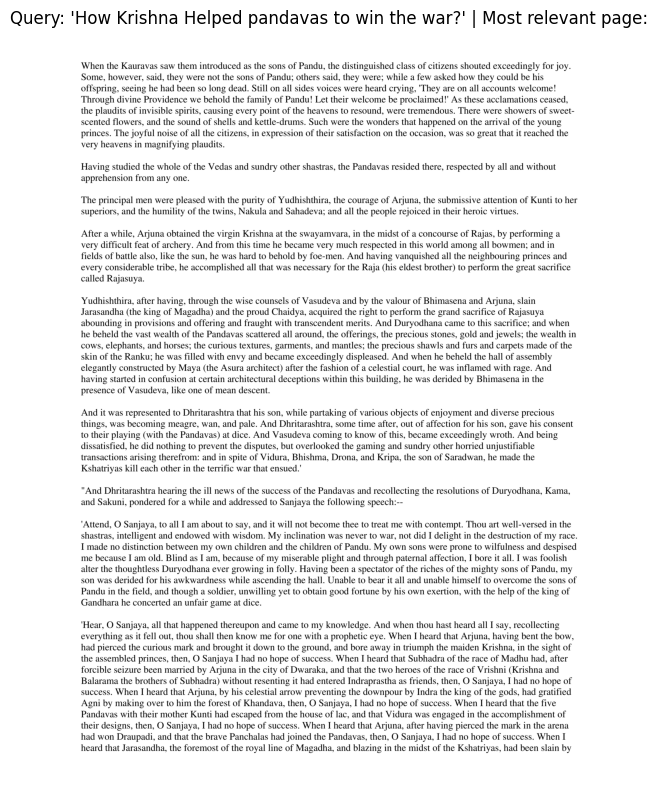

In [97]:
import fitz

# Open PDF and load target page
pdf_path = "Mahabharata.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 ) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
# 1- How Krishna Helped pandavas to win the war?
img.save("First.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [81]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


In [82]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [94]:
query = "How Krishna Helped pandavas to win the war?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 14073 embeddings: 0.00008 seconds.


(tensor([0.6920, 0.6838, 0.6614, 0.6582, 0.6500], device='cuda:0'),
 tensor([ 1103,  4756,  1710,  7626, 13495], device='cuda:0'))

In [96]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 14073 embeddings: 0.00007 seconds.
Query: How Krishna Helped pandavas to win the war?

Results:
Score: 0.6920
Drupada's son also possesseth every accomplishment, and is attached to the
Pandavas.Therefore, I do not think that the Pandavas can now be injured by any
subtle means in thy power.But, O bull  amongst men, this is what is good and
advisable for us now, viz.,to attack and smite them till they are
exterminated.Let this  course recommend itself to thee.As long as our party is
strong and that of the king of the Panchalas is weak, so long strike  them
without any scruple.O son of Gandhari, as long as their innumerable vehicles and
animals, friends, and friendly tribes are  not mustered together, continue, O
king, to exhibit thy prowess.As long as the king of the Panchalas together with
his sons  gifted with great prowess, setteth not his heart upon fighting with
us, so long, O king, exhibit thy prowess.And, O king, exert  thy prowess before
he of t

In [85]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 8 GB


In [86]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 8 | Recommended model: Gemma 2B in 4-bit precision.
use_quantization_config set to: True
model_id set to: google/gemma-2b-it
